# Magnetic Spots in HR~7495?

In [30]:
%matplotlib inline
%run notebook_setup.py

<Figure size 640x480 with 0 Axes>

In [31]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
from corner import corner
import lightkurve as lk

starry.config.quiet = True

### HR7495 Known Proprierties

In [32]:
## Things we'll assume are known (HR7495)
inc = 21.0 # Inclination
P = 1.447  # d (spike period)
vrot = 113 # km/s
Rstar = 3.3 # Rsun
Aspike = 173.3 # ppm

## SPOT Modeling
We're going to use an estimate of $\delta L/L \sim 0.0006$, which comes from Eq. (3) with f=1 and the limits for the observed surface magnetic field (<10 G). Then the filling factor is accounted for by adjusting the value of the spot radius in the model

In [33]:
## Spot Properties (first Guess)
## We're using an estimate of DL/L ~ 0.0006, which comes from Eq. (3) with f=1 (filling factor is accounted for by radius below)
truth = dict(contrast=-0.0006, radius=45, lat=60, lon=30) # Note Negative Contrast = Bright Spot, Positive Contrast = Dark Spot

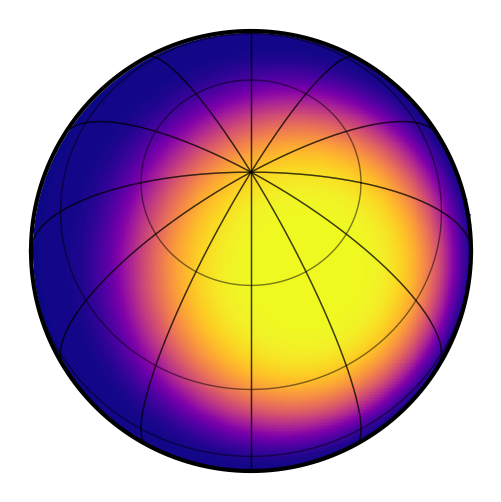

In [35]:
## Brightness Map
map = starry.Map(ydeg=10, udeg=2, rv=False)
map.inc = inc # Inclination angle  (21 Deg)
map.spot(
    contrast=truth["contrast"],
    radius=truth["radius"],
    lat=truth["lat"],
    lon=truth["lon"],
)
map.show()
#map.save(FIGURES+'HR7495_spot_map.pdf',bbox_inches='tight')
#plot = map.show()
#plt.tight_layout()
#plt.savefig(FIGURES+'HR7495_spot_map.pdf',bbox_inches='tight')

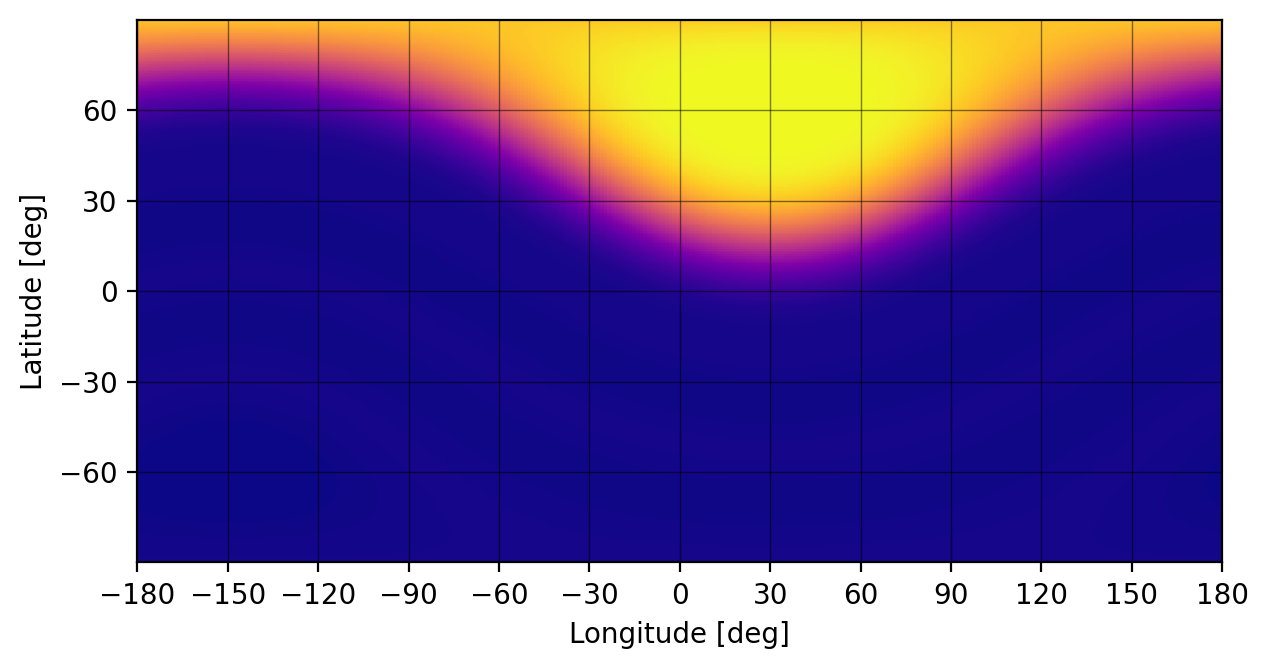

In [36]:
map.show(projection="rect")

In [37]:
## Rotating Brightness Map + RV Map
map = starry.Map(ydeg=10, udeg=2, rv=True)
map.inc = inc
map.spot(
    contrast=truth["contrast"],
    radius=truth["radius"],
    lat=truth["lat"],
    lon=truth["lon"],
)

map.obl = 60 # Obliquity angle. Only matters for showing purposes 
map.veq = -vrot*1000 # in m/s (Positive or negative to determine direction of rotation)
#map.alpha = 0.3 # Surface shear. Not using it for now

map.show(rv=False, theta=np.linspace(0, 360, 50)) # Shows brightness map
map.show(rv=True, theta=np.linspace(0, 360, 50))  # Shows radial velocity map (note it's hard to see, but the spot change it from pure dipole)

# Limb Darkening
map[1] = 0.5
map[2] = 0.25

### Generate Synthetic Light Curve with SPOT Model

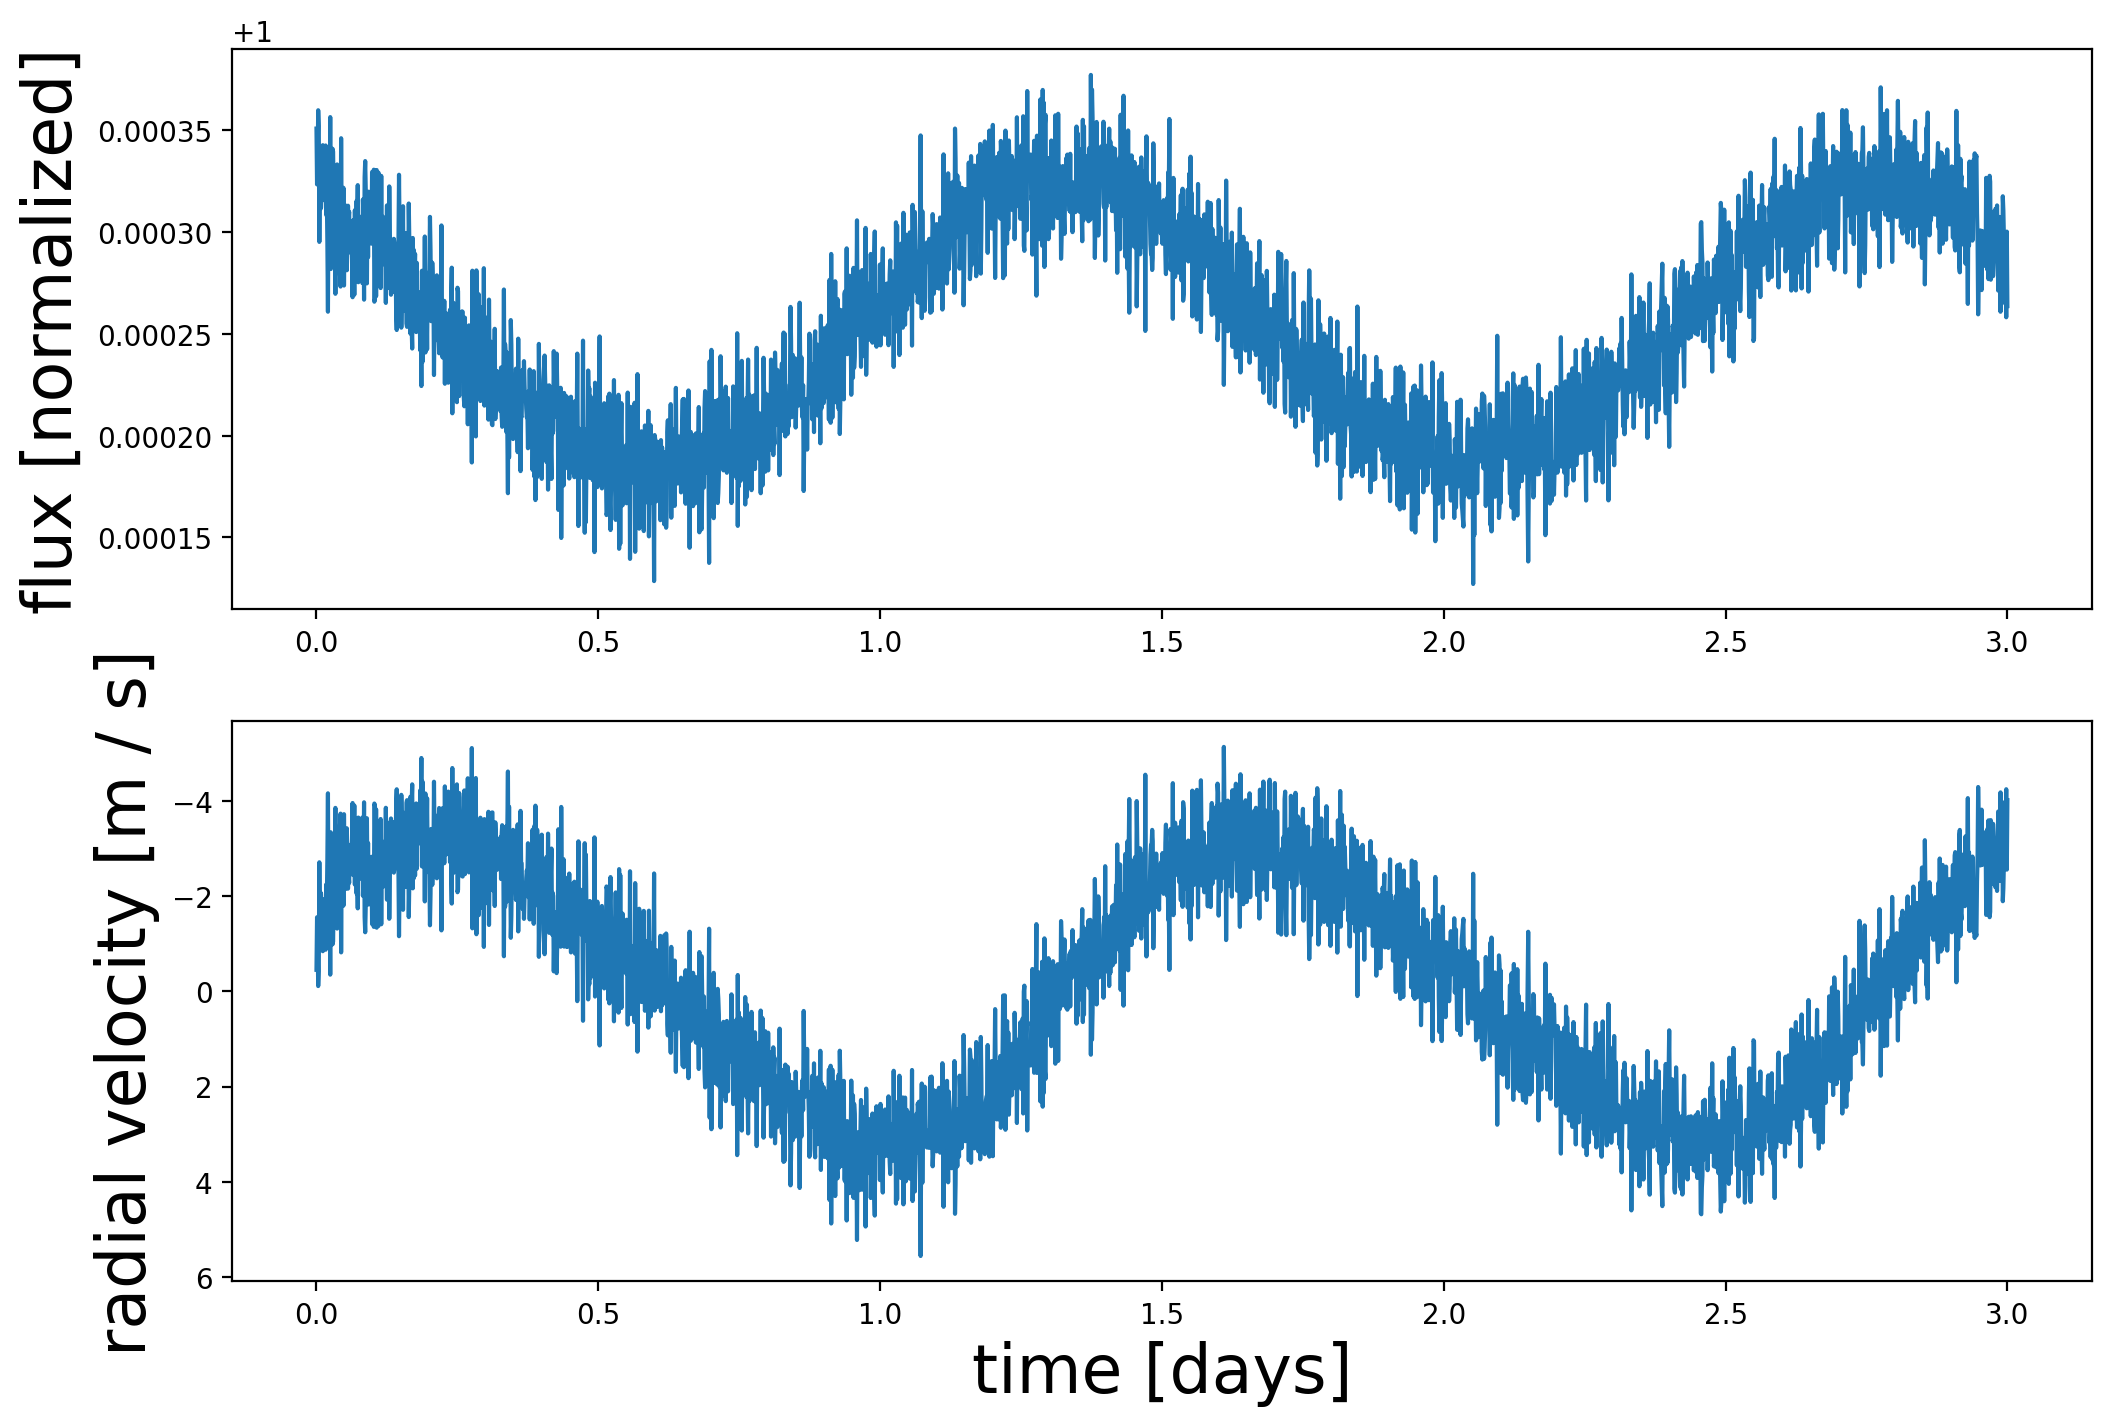

In [38]:
t = np.linspace(0, 3.0, 2951)

flux0 = map.flux(theta=360.0 / P * t)
np.random.seed(0)
flux_err = 2e-5
flux = flux0 + flux_err * np.random.randn(len(t))

# Compute the  RV signal
rv0 = map.rv(theta=360.0 / P * t)
np.random.seed(0)
rv_err = 8e-1
rv = rv0 + rv_err * np.random.randn(len(t))

flux_numpy = flux.eval()
rv_numpy = rv.eval()

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, flux_numpy)
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])

ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [normalized]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);

### Some Analytical Expectations for Luminosity and RV fluctuations
If a bright spot is changing the bolometric luminosity by a factor $\Delta L/L \approx2\times10^{-4}$ and the star is rotating with vsini$\approx$ 41 km/s, then one should expect a maximum doppler shift of something of the order $\delta v \sim f\,\Delta L/L\,$vsini, where $f$ is the filling factor. Plugging in numbers and remembering that the above 50\% filling factor this scaling breaks down (a spot can only blueshift or redshift half of the star at the time), one gets the max RV change to be $ 2\times10^{-4}*0.5*41\approx 4\times10^{-3}$ km/s or 4 m/s.

## Multiple SPOTS Model

We're going to start with a two spots model that tries to account for a bright spot surrounded by a dark ring. This configuration is inspired by flux conservation arguments, although it's unclear what these out-of-thermal equilibrium spots could look like. In the Sun 
it is known that extra flux emerges from the regions surrounding dark spots. So it's possible a similar phenomena occurs for bright spots.

In [47]:
# True values
truth1 = dict(contrast1=-0.0020, radius1=50, lat1=25, lon1=30)  # Remember the brightness of the bright spot is contrast1 + Contrast 2 !!
truth2 = dict(contrast2=+0.0008, radius2=85, lat2=25, lon2=30)

truth1 = dict(contrast1=-0.0019, radius1=50, lat1=25, lon1=30)  # Remember the brightness of the bright spot is contrast1 + Contrast 2 !!
truth2 = dict(contrast2=+0.0008, radius2=85, lat2=25, lon2=30)

truth3 = dict(contrast3=-0.004, radius3=20, lat3=25, lon3=280)
truth4 = dict(contrast4=+0.002, radius4=25, lat4=25, lon4=280)

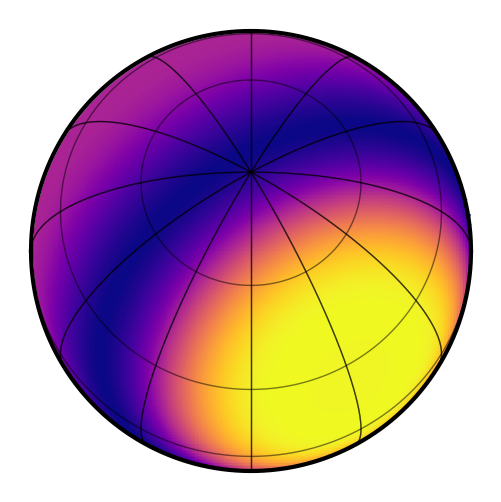

In [49]:
## Brightness Map
map = starry.Map(ydeg=10, udeg=2, rv=False)
map.inc = inc # Inclination angle  (21 Deg)
map.spot(
    contrast=truth1["contrast1"],
    radius=truth1["radius1"],
    lat=truth1["lat1"],
    lon=truth1["lon1"],
)
map.spot(
    contrast=truth2["contrast2"],
    radius=truth2["radius2"],
    lat=truth2["lat2"],
    lon=truth2["lon2"],
)
map.show()

In [40]:
map = starry.Map(ydeg=10,udeg=2,rv=True)
map.inc = inc
map.spot(
    contrast=truth1["contrast1"],
    radius=truth1["radius1"],
    lat=truth1["lat1"],
    lon=truth1["lon1"],
)
map.spot(
    contrast=truth2["contrast2"],
    radius=truth2["radius2"],
    lat=truth2["lat2"],
    lon=truth2["lon2"],
)

# map.spot(
#     contrast=truth3["contrast3"],
#     radius=truth3["radius3"],
#     lat=truth3["lat3"],
#     lon=truth3["lon3"],
# )
# map.spot(
#     contrast=truth4["contrast4"],
#     radius=truth4["radius4"],
#     lat=truth4["lat4"],
#     lon=truth4["lon4"],
# )

vrot = 113 # km/s
map.obl = 60
map.veq = -vrot*1000 # in m/s

map.show(rv=False, theta=np.linspace(0, 360, 50))
map.show(rv=True, theta=np.linspace(0, 360, 50))

# Limb Darkening
map[1] = 0.5
map[2] = 0.25

### Synthetic Lightcurve

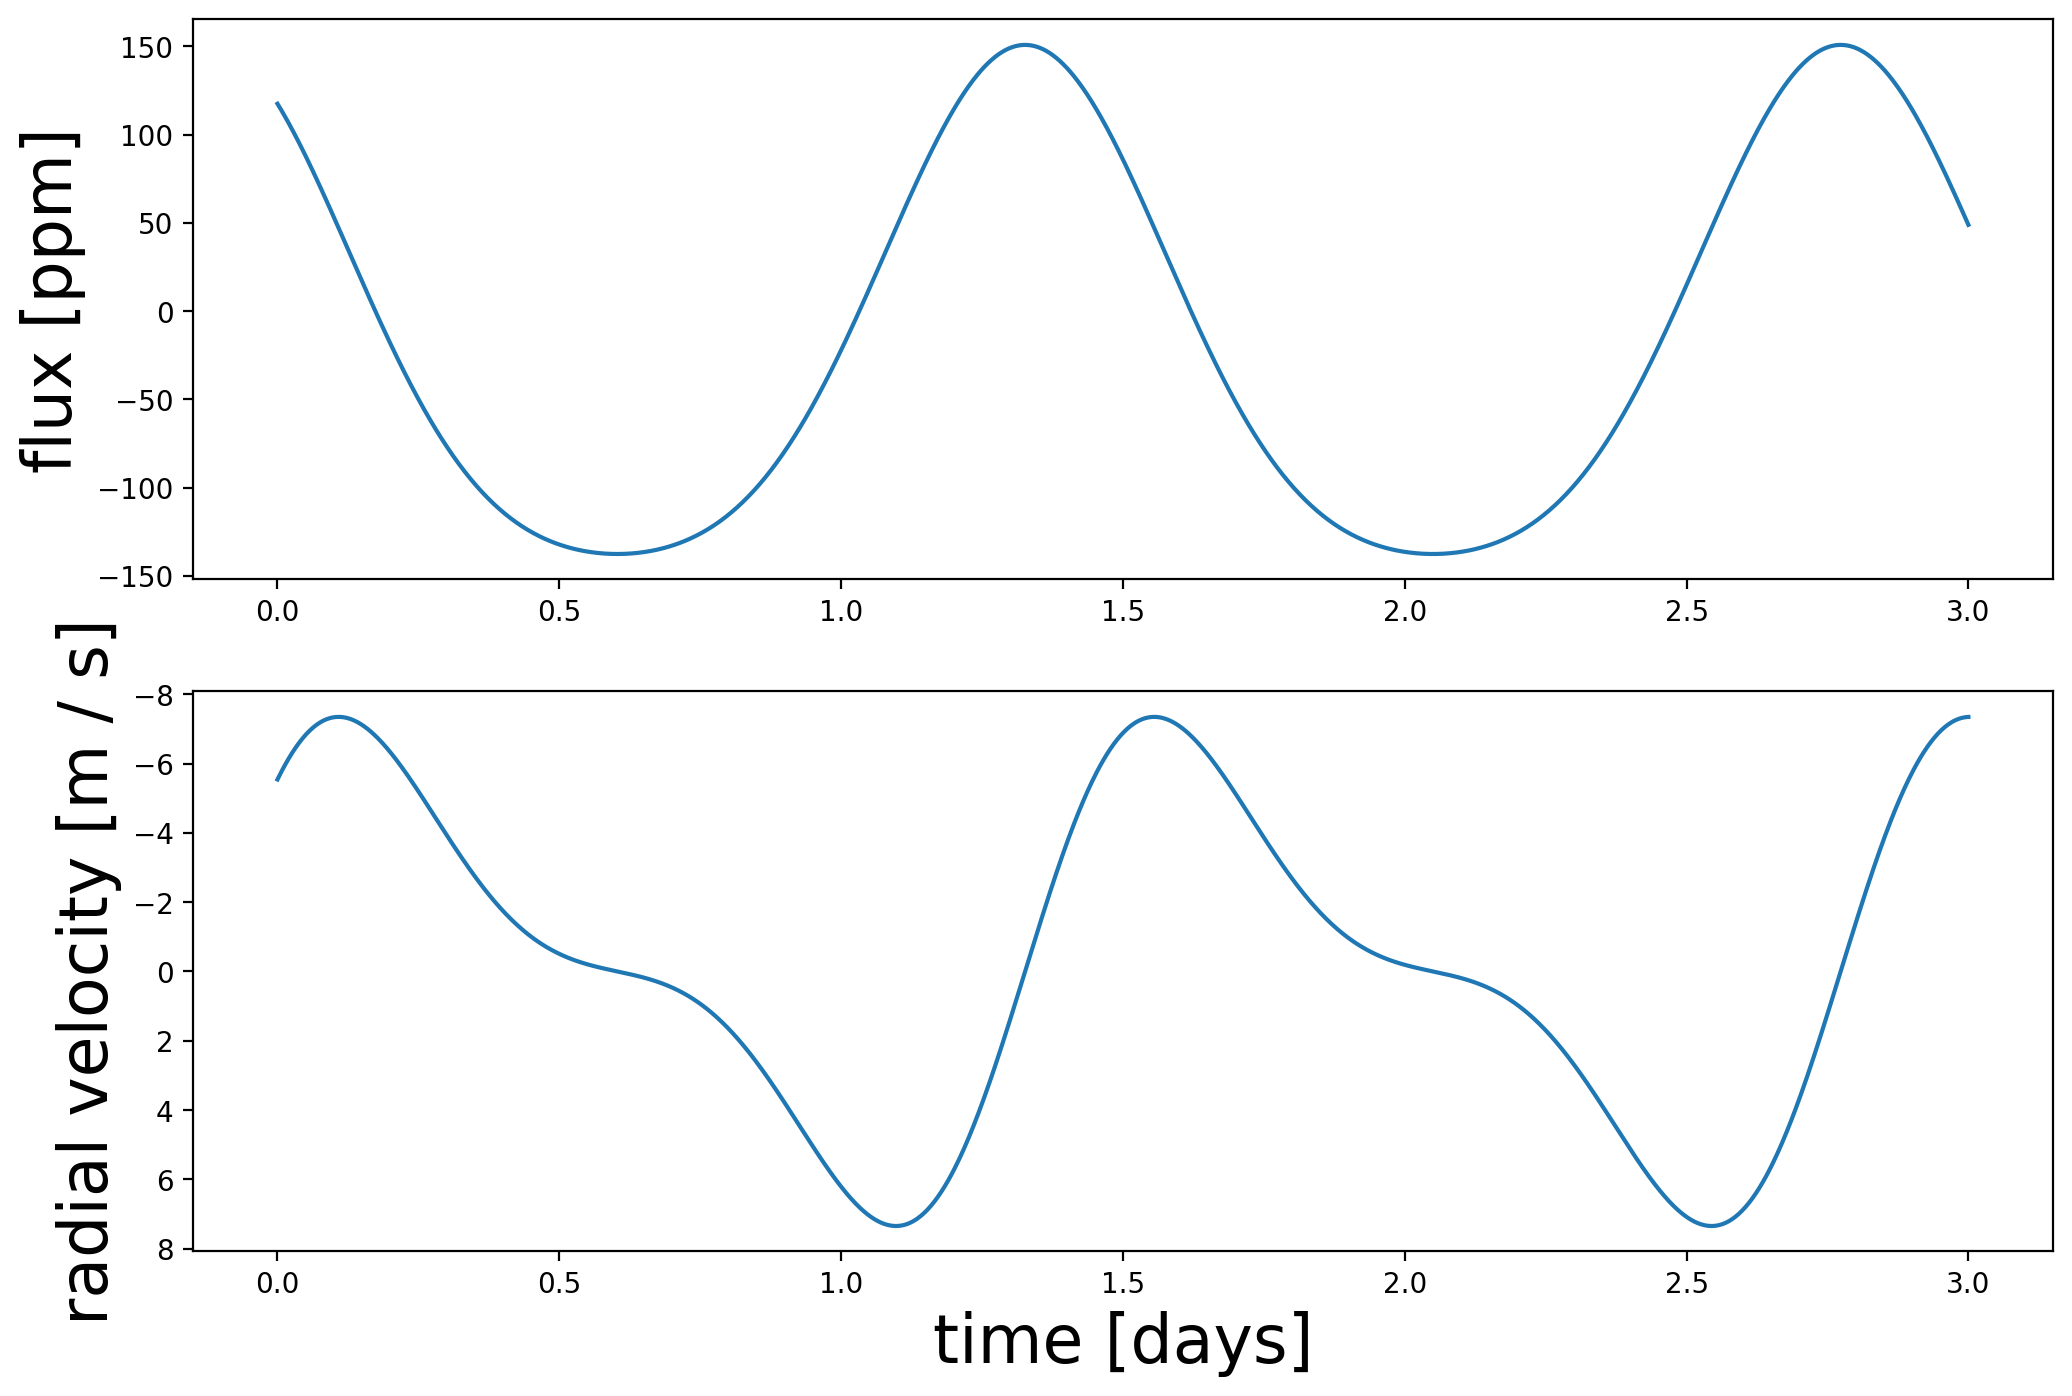

In [41]:
t = np.linspace(0, 3, 1481) # This should be (0,3,2951) to make it work with the observed dataset

flux0 = map.flux(theta=360.0 / P * t)
np.random.seed(0)
flux_err = 0# 1e-5
flux = flux0 + flux_err * np.random.randn(len(t))

# Compute the  RV signal
rv0 = map.rv(theta=360.0 / P * t)
np.random.seed(0)
rv_err = 0 # 8e-1
rv = rv0 + rv_err * np.random.randn(len(t))

flux_numpy = flux.eval()
rv_numpy = rv.eval()

ppm = 1e-6
# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, (flux_numpy-1)/ppm)
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [ppm]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);

### Some Important Considerations
This 2 Spots model can reproduce a number of features in the Kepler observations. The lightcurve is reproduced both qualitatively  and quantitatively (approximately). The RV series is reproduced qualitatively, showing the most important expected features (0 km/s at the brightness peak, and the right red/blue-shift pattern). Note that we had to choose a specific direction of rotation to make this look like the observation. The biggest challenge remains the amplitude of the RV fluctuations, which is off by a factor of about 20. It seems hard to explain RV and photometry purely with spots. Pulsations are likely to be occurring. 

### Overplot Data

In [42]:
search_result_2022 = lk.search_lightcurve('KIC 9163520', mission='TESS', sector = 55)
lc_2022 = search_result_2022.download_all()
lc_2022

LightCurveCollection of 3 objects:
    0: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

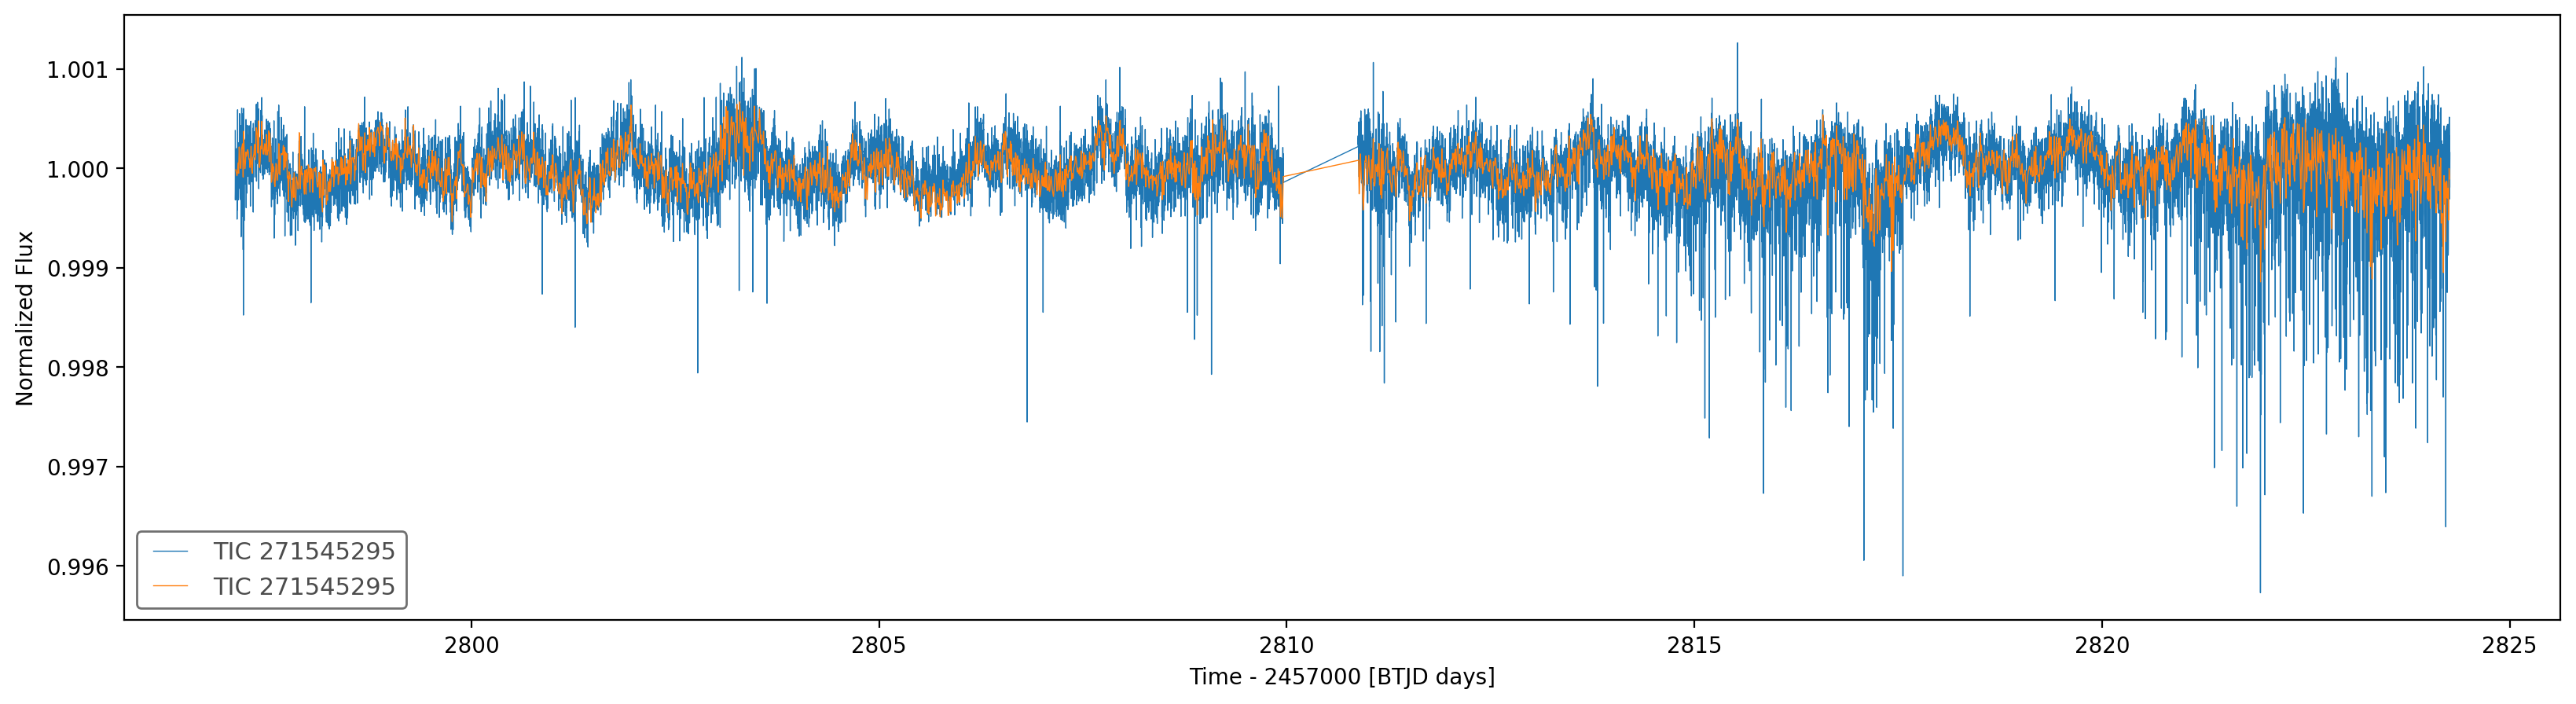

In [43]:
fig, ax = plt.subplots(figsize=(20,5))
lc_2022[0].plot(ax=ax,normalize=True);
lc_2022[1].plot(ax=ax,normalize=True);

### Note: It seems I can replicate the shape of the folded lightcurve in Fig.10 using P_folding = 2*P = 2.95d

1.4756817854920776 d


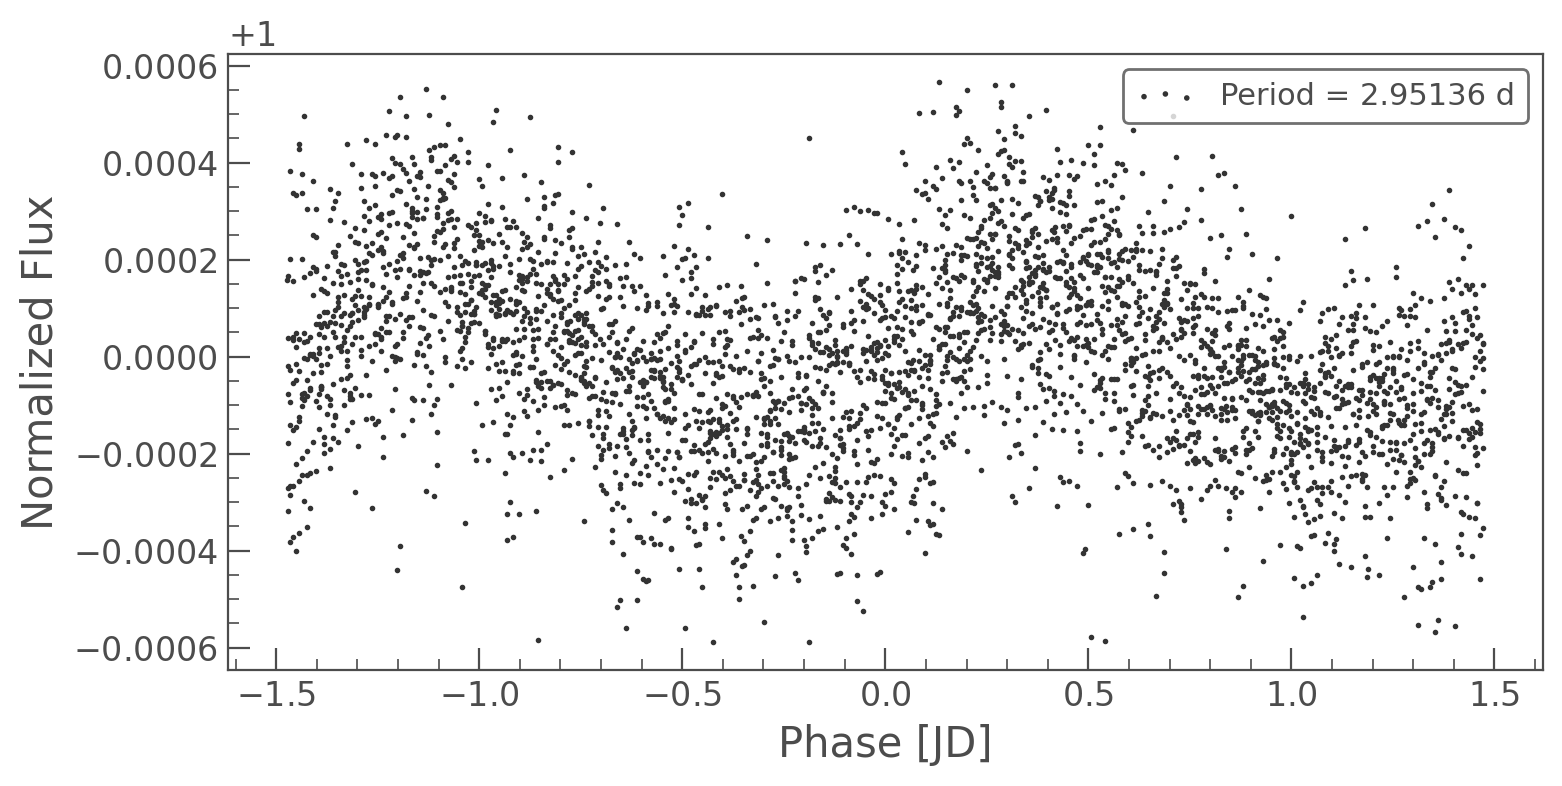

In [44]:
pg = lc_2022[1].normalize(unit='ppm').to_periodogram()
period = pg.period_at_max_power
print(period)

flat_lc = lc_2022[1].flatten(window_length=1001)
clipped_lc = flat_lc.remove_outliers(sigma=3)
folding=2.0*period
clipped_lc.fold(folding).scatter(label=fr'Period = {folding.value:.5f} d');

A = clipped_lc.fold(period=folding) 
t_data = A.phase.to_value('jd')#+1.5
flux_data = A.flux

## Show Data and 2 Spots Model

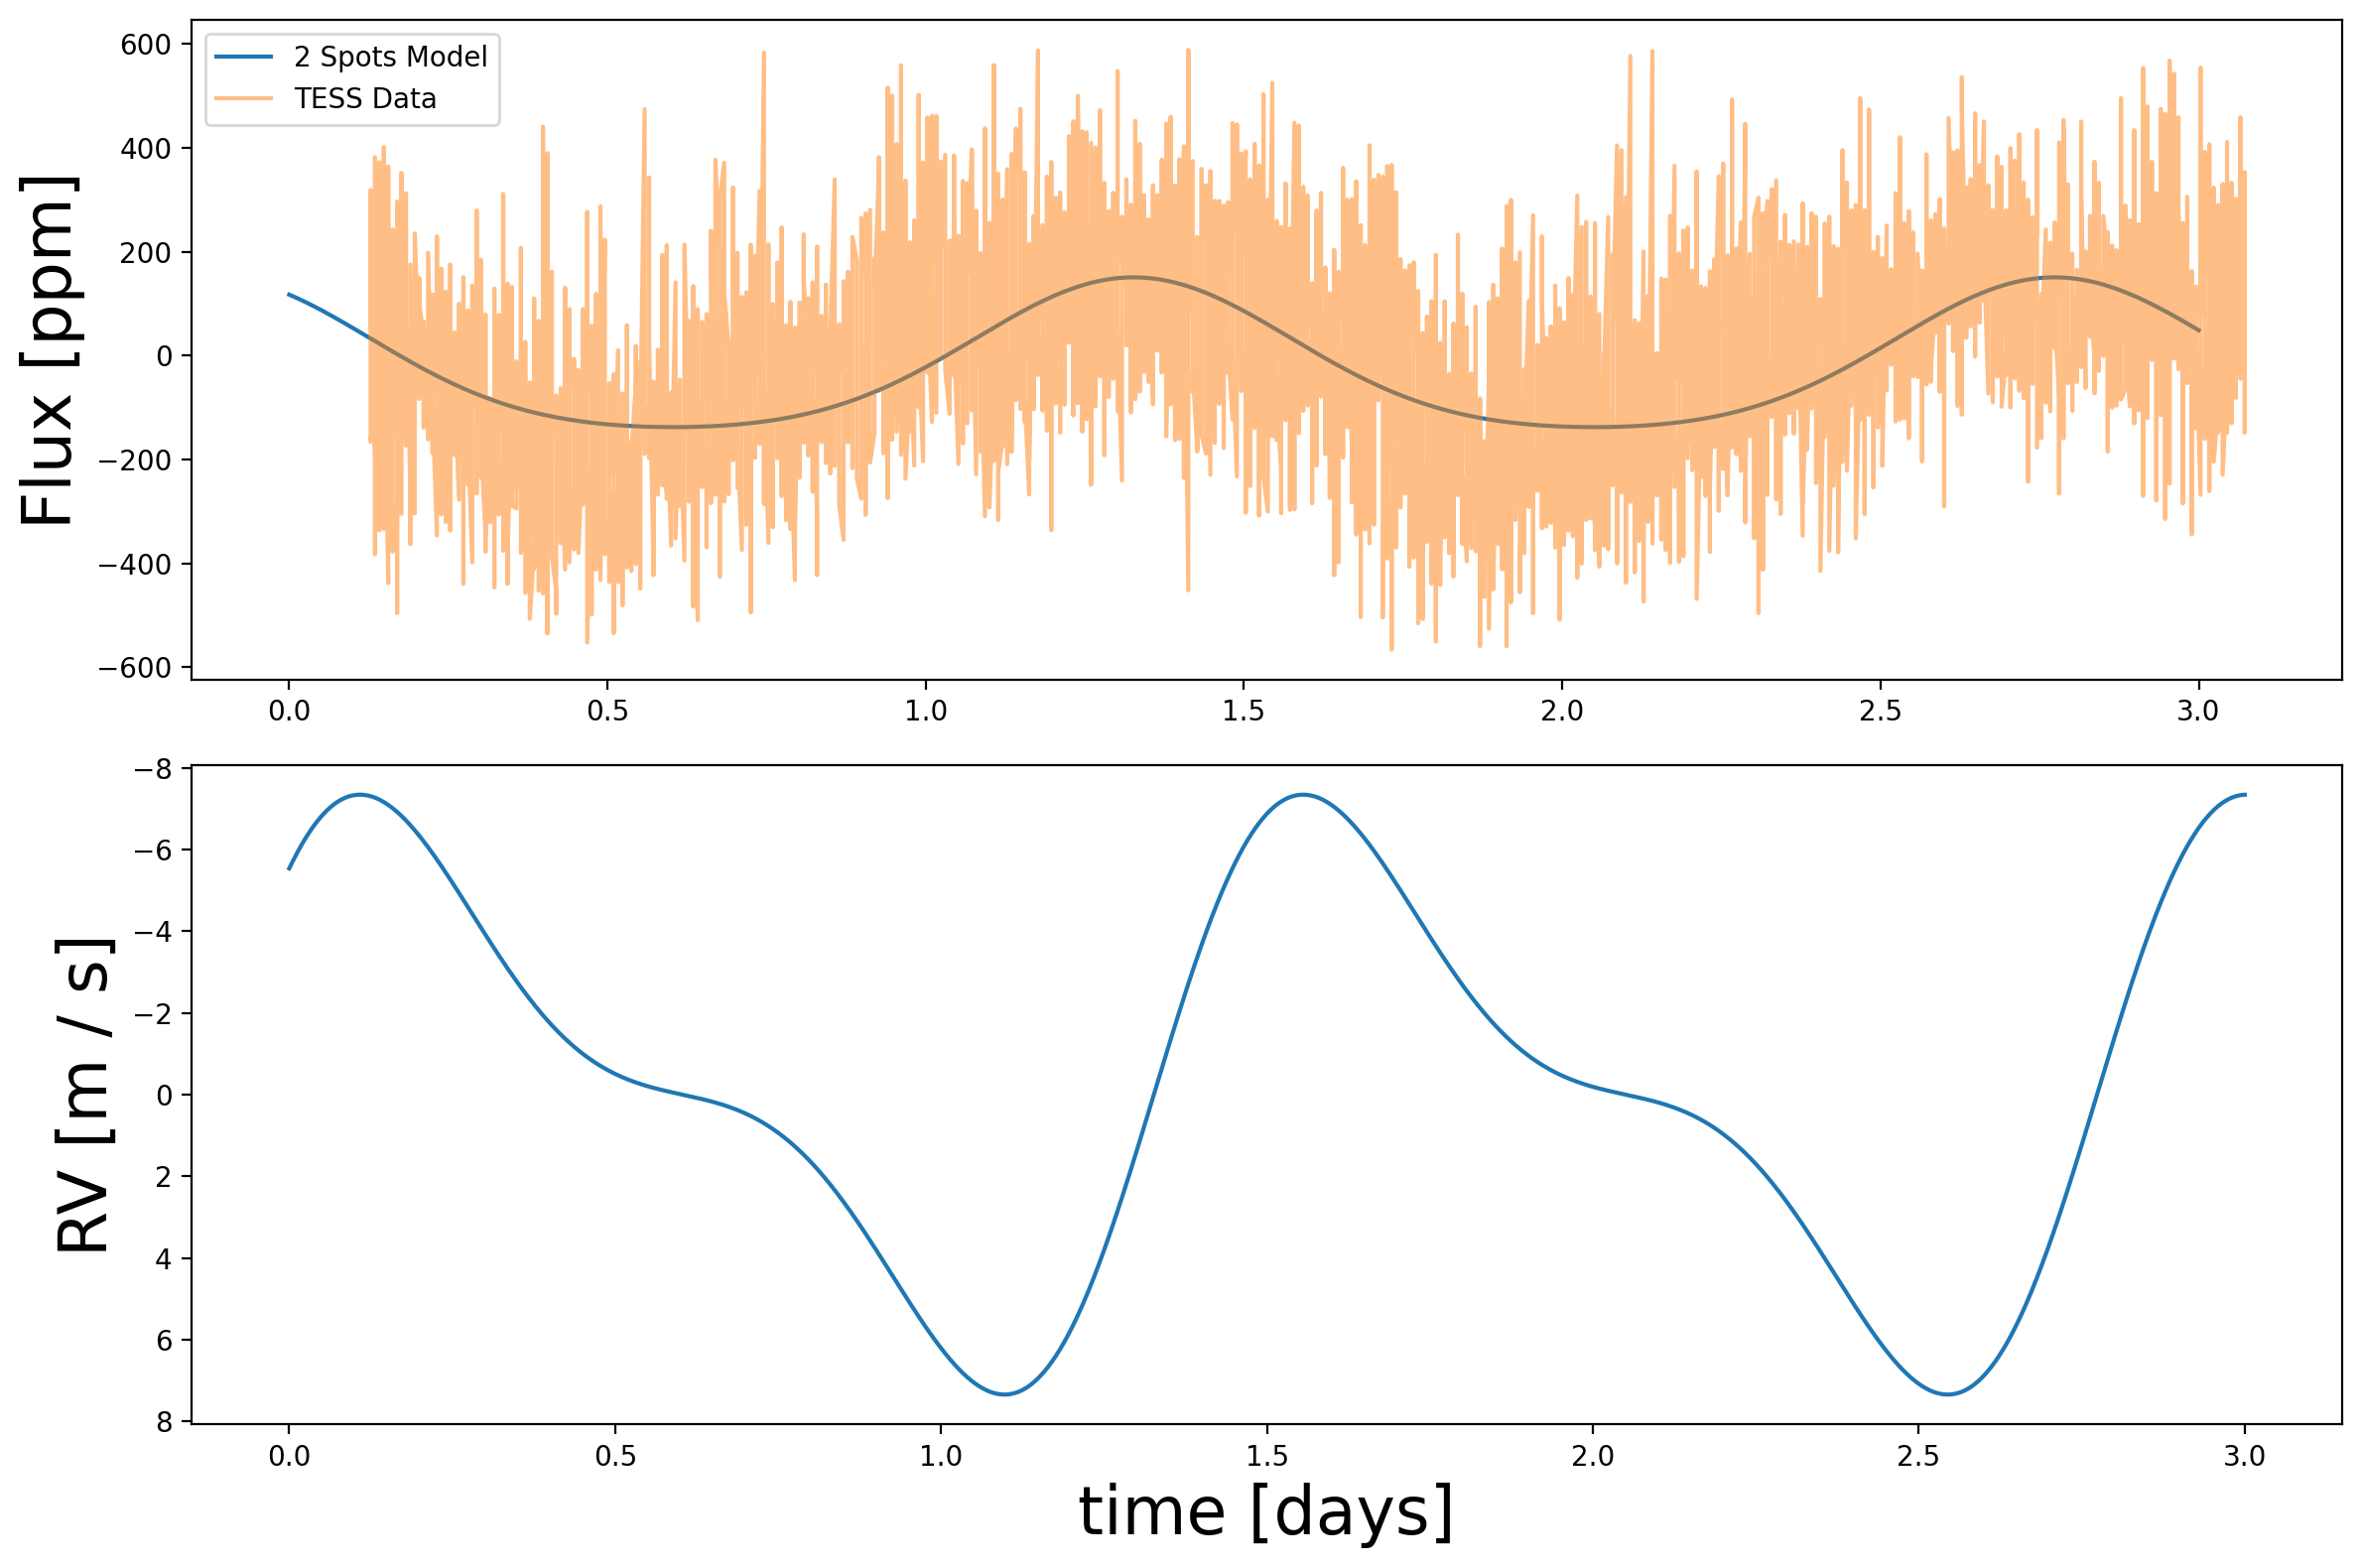

In [45]:
FIGURES='./figures/'
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, (flux_numpy-1)/ppm,label='2 Spots Model')
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("Flux [ppm]", fontsize=24)
ax[1].set_ylabel("RV [m / s]", fontsize=24);

ax[0].plot(t_data+1.6, -(flux_data-1)/ppm,alpha=0.5,label= 'TESS Data')
ax[0].legend()

plt.tight_layout()
plt.savefig(FIGURES+'HR7495_spot_model.pdf',bbox_inches='tight')